<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/unsupervised_learning/Hidden_Markov_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [197]:
!pip install hmmlearn
!pip install yfinance

In [198]:
from hmmlearn import hmm
import yfinance as yf

In [416]:
df = yf.download('^nsei',start='2021-01-01')#period='max'
#median = df.loc[df['Close']<10, 'Close'].median()
#df["Close"] = np.where(df["Close"] <10, df.Close.mean(),df['Close'])


[*********************100%***********************]  1 of 1 completed


In [417]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

In [418]:
df.head(1)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,14104.349609,14147.950195,13953.75,14132.900391,14132.900391,495000


In [419]:
returns = np.log(df['Close']).diff(8)

In [420]:
returns.dropna(inplace=True)

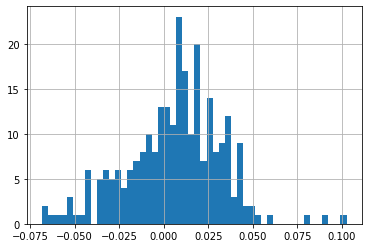

In [421]:
returns.hist(bins=50);

In [422]:
model = hmm.GaussianHMM(n_components=2, covariance_type="diag")

In [423]:
#retu = np.column_stack([returns]) =====> returns.to_numpy().reshape(-1, 1)


In [424]:
X = returns.to_numpy().reshape(-1, 1)
print(X.shape)
model.fit(X)

(259, 1)


GaussianHMM(n_components=2)

In [425]:
Z = model.predict(X)

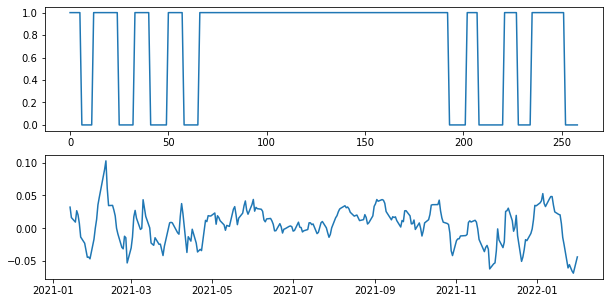

In [426]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.subplot(211)
plt.plot(Z)
plt.subplot(212)
plt.plot(returns);

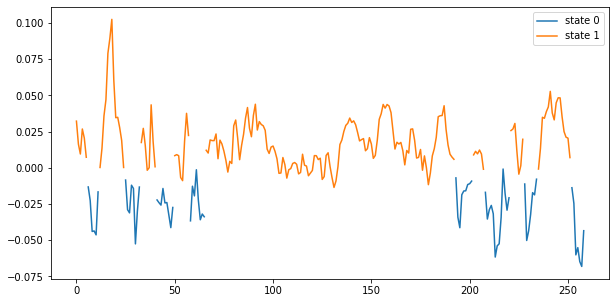

In [427]:
# we want to draw different segments in different colors according to state
fig, ax = plt.subplots(figsize=(10, 5))

# first create arrays with nan
returns0 = np.empty(len(Z))
returns1 = np.empty(len(Z))
returns0[:] = np.nan
returns1[:] = np.nan

# fill in the values only if the state is the one corresponding to the array
returns0[Z == 0] = returns[Z == 0]
returns1[Z == 1] = returns[Z == 1]
plt.plot(returns0, label='state 0')
plt.plot(returns1, label='state 1')
plt.legend();

In [428]:
# transition matrix
model.transmat_

array([[0.88502501, 0.11497499],
       [0.05106851, 0.94893149]])

In [429]:
'''
# try to set the transition matrix intuitively
model.transmat_ = np.array([
  [0.999, 0.001],
  [0.001, 0.999],                           
])
'''

'\n# try to set the transition matrix intuitively\nmodel.transmat_ = np.array([\n  [0.999, 0.001],\n  [0.001, 0.999],                           \n])\n'

In [430]:
returns[Z==0].mean()

-0.028256270036352

In [431]:
returns[Z==1].mean()

0.01799697614964287

In [432]:
zero=(returns[Z==0]).mean()

In [433]:
one=(returns[Z==1]).mean()

In [434]:
print(f'zero {zero}')
print(f'one {one}')

zero -0.028256270036352
one 0.01799697614964287


In [435]:
# run inference again
Z = model.predict(X)
# first create arrays with nan
returns_vol = np.empty(len(Z))
returns_vol[:] = np.nan
if one>0:
  returns_vol[Z==0]=1
  returns_vol[Z==1]=0
elif one<0:
  returns_vol[Z==0]=0
  returns_vol[Z==1]=1
ret=returns.reset_index()
zi= pd.concat([ret.Date,ret.Close,pd.Series(Z),pd.Series(returns_vol)],axis=1)
zi=zi.set_index('Date')
zi.columns=['pct_chg','pred','Volatility']



In [436]:
#print(abcd)

In [437]:
zi.to_csv('hmm.csv')

In [438]:
def plot_buy_sell_signal(df):
  reg1=[]
  reg2=[]
  for i in range(len(df)):
    if df.Volatility.iloc[i]==1 and df.Volatility.iloc[i-1]==0 :
      reg1.append(i)
    elif df.Volatility.iloc[i]==0 and df.Volatility.iloc[i-1]==1 :
      reg2.append(i)
  
  return reg1,reg2

In [439]:
sell,buy=plot_buy_sell_signal(zi)

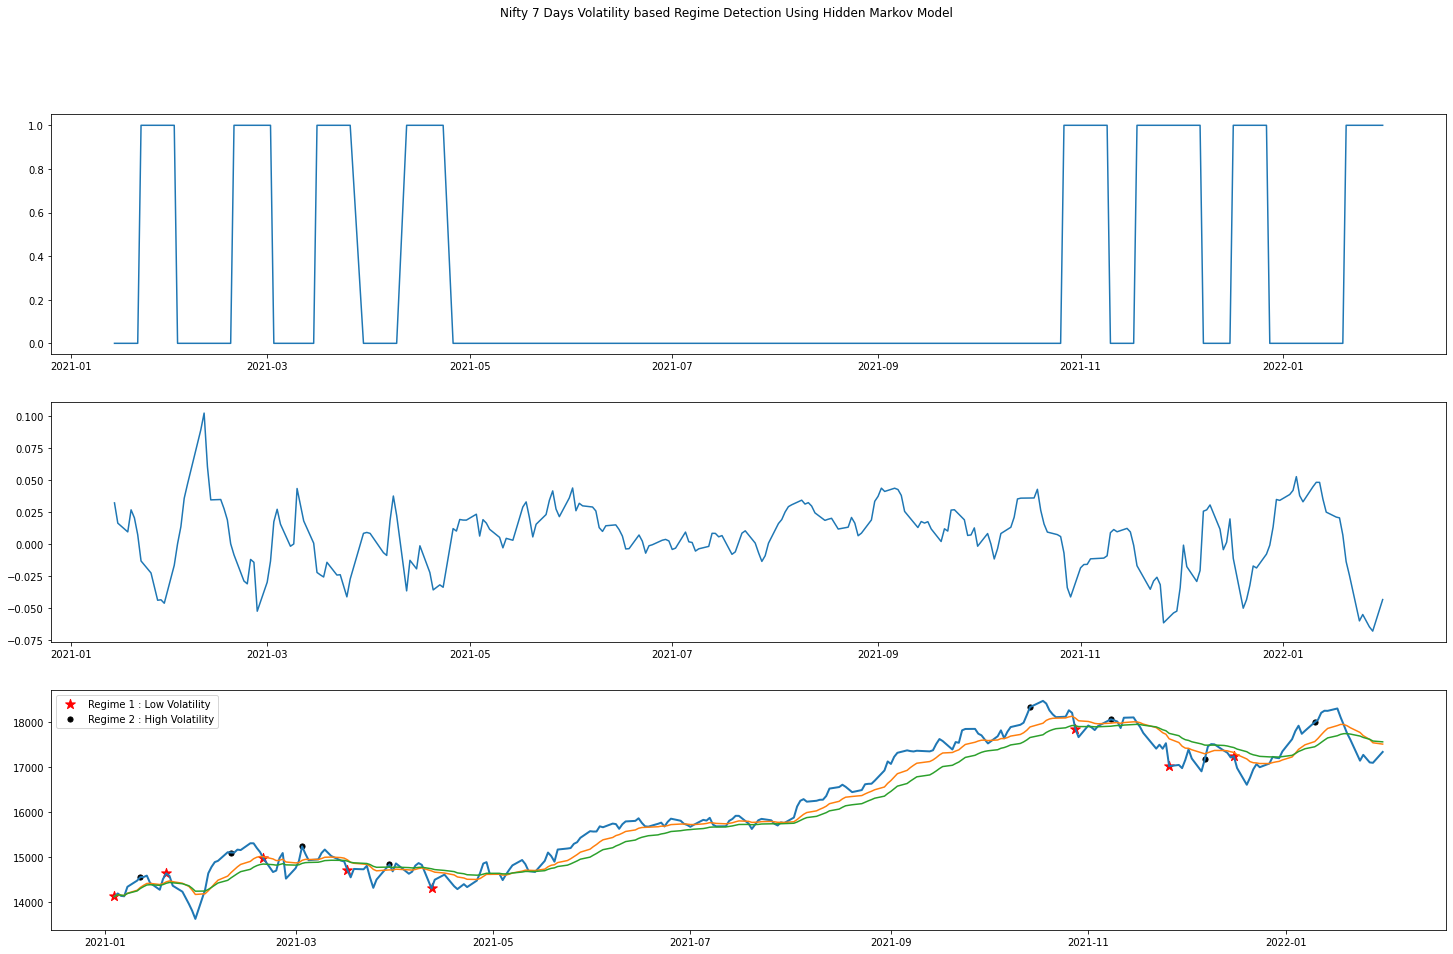

In [440]:
fig, ax = plt.subplots(figsize=(25,15),sharex=True)
plt.subplot(311)
plt.plot(zi.Volatility[:])
plt.subplot(312)
plt.plot(returns[:])
plt.subplot(313)
plt.plot(df['Close'][:],linewidth=2)
plt.plot(df["Close"].ewm(span=13).mean())
plt.plot(df["Close"].ewm(span=26).mean())
plt.scatter(df.iloc[buy][:].index,df.iloc[buy][:].Close,marker='*',s=105,color='r',label='Regime 1 : Low Volatility')
plt.scatter(df.iloc[sell][:].index,df.iloc[sell][:].Close,marker='.',s=105,color='black',label='Regime 2 : High Volatility')
plt.legend()
plt.suptitle('Nifty 7 Days Volatility based Regime Detection Using Hidden Markov Model')
plt.show();

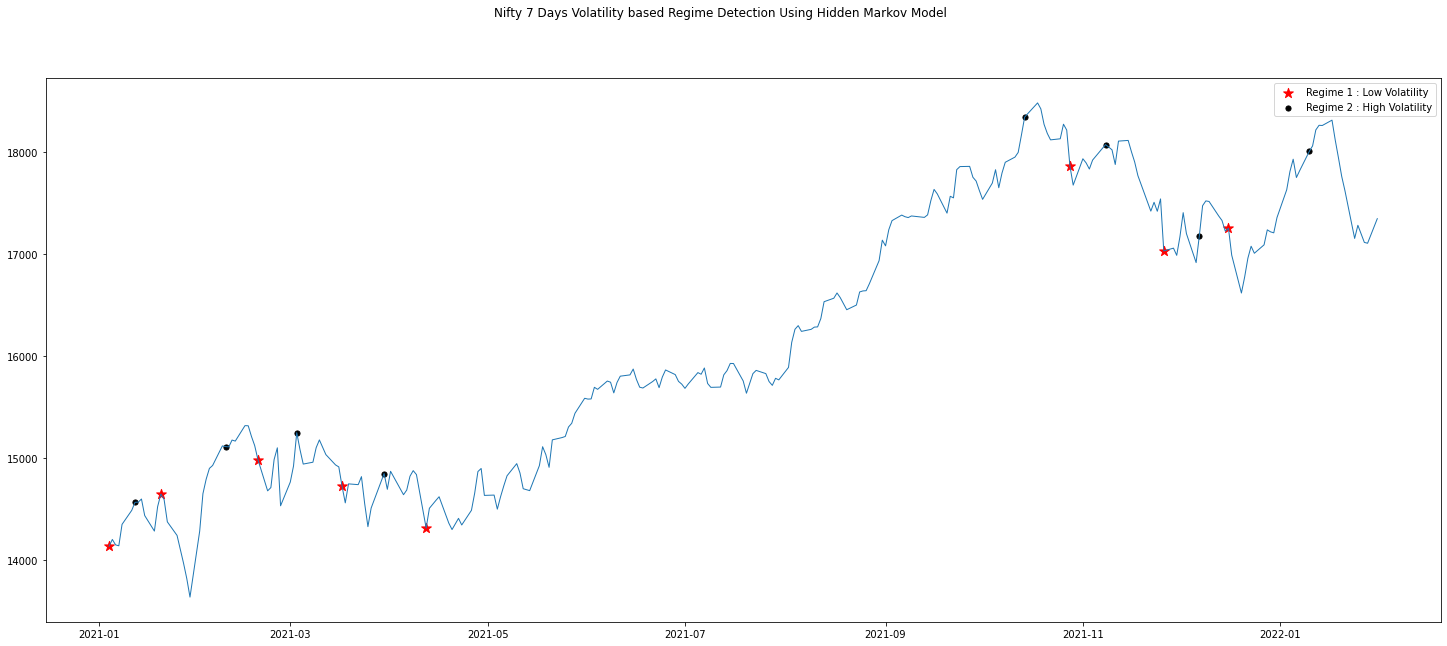

In [441]:
fig, ax = plt.subplots(figsize=(25,10),sharex=True)
plt.plot(df['Close'][:],linewidth=1)
#plt.plot(df["Close"].ewm(span=13).mean(),color='g')
#plt.plot(df["Close"].ewm(span=26).mean(),color='r')
plt.scatter(df.iloc[buy][:].index,df.iloc[buy][:].Close,marker='*',s=105,color='r',label='Regime 1 : Low Volatility')
plt.scatter(df.iloc[sell][:].index,df.iloc[sell][:].Close,marker='.',s=105,color='black',label='Regime 2 : High Volatility')
plt.legend()
plt.suptitle('Nifty 7 Days Volatility based Regime Detection Using Hidden Markov Model')
plt.show();

In [442]:
buy[-1],sell[-1]

(235, 252)

In [443]:
lst=[buy[-1],sell[-1]]
max(lst)

252

In [444]:
df.tail(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-28,17208.300781,17373.5,17077.099609,17101.949219,17101.949219,355300
2022-01-31,17301.050781,17410.0,17264.150391,17342.750000,17342.750000,0


In [445]:
'''
if High_vol=0:
  df.loc[0,'Regime']='High Volatility'
if High_vol=1: 
  df.loc[0,'Regime']='High Volatility' 
'''  

"\nif High_vol=0:\n  df.loc[0,'Regime']='High Volatility'\nif High_vol=1: \n  df.loc[0,'Regime']='High Volatility' \n"

In [446]:
df=pd.concat([df,zi.Volatility],axis=1)